# YDB SQLAlchemy + Jupyter Notebook Example

## Prepare simple dataset

### Download

In this example we will use [Mall Customers Dataset](https://www.kaggle.com/datasets/hosammhmdali/mall-customers-dataset)

First of all, we should download it and get path to csv file:

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
%pip install --upgrade pip --quiet
%pip install kagglehub --quiet

import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("hosammhmdali/mall-customers-dataset")

# Retrieve csv file path
dataset_dir = os.listdir(path)
dataset_name = [name for name in dataset_dir if name.endswith(".csv")]
dataset_path = f"{path}/{dataset_name[0]}"

Let's take a look how this dataset looks like

In [3]:
%pip install pandas --quiet
import pandas as pd
df = pd.read_csv(dataset_path)
df.head()

Note: you may need to restart the kernel to use updated packages.


CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

### Transform

Let's rename column names to get rid of spaces and simplify readability

In [4]:
df = df.rename(columns={
    "CustomerID": "id",
    "Genre": "sex",
    "Age": "age",
    "Annual Income (k$)": "income",
    "Spending Score (1-100)": "spending_score",
})
df.head()

id     sex  age  income  spending_score
0   1    Male   19      15              39
1   2    Male   21      15              81
2   3  Female   20      16               6
3   4  Female   23      16              77
4   5  Female   31      17              40

Dataset is ready for work!

## Actions with YDB

### Create SQLAlchemy Engine and connect

First of all, we have to install YDB SA Dialect:

In [ ]:
%pip install ydb-sqlalchemy==0.1.3 --quiet

Target YDB installation uses service account to auth. In block below we load service accont json and install additional dependency to use SA auth.

Skip this part if your YDB installation uses another auth method.



Let's create SA engine and connection

In [6]:
import sqlalchemy as sa

engine = sa.create_engine("ydb+ydb_sync://localhost:2136/local")
conn = engine.connect()

Done! We are ready for work with YDB via sqlalchemy!

### Create database

There's no way to specify PK directly from `df.to_sql`, since `YDB` does not support tables without PK we have to prepare database first

In [7]:
table_name = "mall_customers"

conn.execute(sa.DDL(f"DROP TABLE IF EXISTS {table_name}"))
conn.execute(sa.DDL(
    f"""
    CREATE TABLE {table_name} (
	`id` Int64, 
	`sex` UTF8, 
	`age` Int64, 
	`income` Int64, 
	`spending_score` Int64,
    primary key (id)
    )
    """
))

### Pandas DataFrame integrations

YDB Dialect is compatible with `DataFrame.to_sql` and `DataFrame.read_sql*` operations. Let's show example how to use it.

*Note: Current YDB dialect version is not optimised to work with multiple inserts, it is better to use YDB CLI to load huge datasets to YDB.*

Loading dataframe to YDB table:

In [8]:
df.to_sql(table_name, conn, if_exists='append', index=False, method=None)

-1

Loading YQL Query ResultSet to DataFrame:

In [9]:
new_df = pd.read_sql(f"SELECT * FROM {table_name}", conn)
new_df

age   id  income     sex  spending_score
0     19    1      15    Male              39
1     21    2      15    Male              81
2     20    3      16  Female               6
3     23    4      16  Female              77
4     31    5      17  Female              40
..   ...  ...     ...     ...             ...
195   35  196     120  Female              79
196   45  197     126  Female              28
197   32  198     126    Male              74
198   32  199     137    Male              18
199   30  200     137    Male              83

[200 rows x 5 columns]

Loading full YDB table to DataFrame:

In [10]:
table_df = pd.read_sql_table(table_name, conn)
table_df

id     sex  age  income  spending_score
0      1    Male   19      15              39
1      2    Male   21      15              81
2      3  Female   20      16               6
3      4  Female   23      16              77
4      5  Female   31      17              40
..   ...     ...  ...     ...             ...
195  196  Female   35     120              79
196  197  Female   45     126              28
197  198    Male   32     126              74
198  199    Male   32     137              18
199  200    Male   30     137              83

[200 rows x 5 columns]

That's it! From this moment you are free to do whatever you like with loaded DataFrame from YDB:

Note: you may need to restart the kernel to use updated packages.


<Axes: xlabel='age', ylabel='spending_score'>

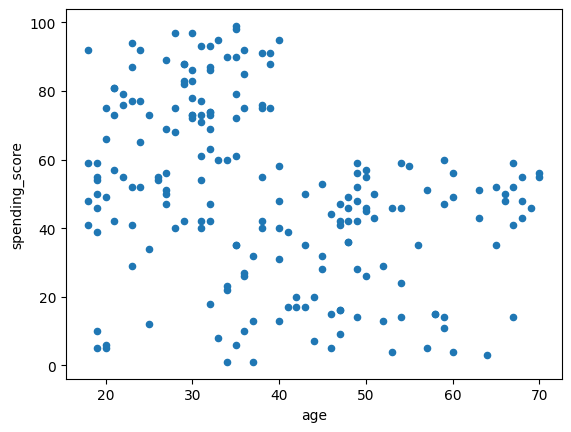

In [11]:
%pip install matplotlib --quiet
import matplotlib.pyplot as plt

table_df.plot(x='age', y='spending_score', kind='scatter')

### JupySQL integrations

YDB SQLAlchemy dialect is compatible with JupySQL. Let's install it and use `sql magic` comes with it.

In [ ]:
%pip install jupysql --quiet
%load_ext sql

We should connect our SQLAlchemy engine with JupySQL:

In [13]:
%sql engine

Now we are free to use SQL expressions right from Notebook:

In [14]:
%sql SELECT * FROM mall_customers

Running query in 'ydb+ydb_sync://localhost:2136/local'

200 rows affected.

+-----+----+--------+--------+----------------+
| age | id | income |  sex   | spending_score |
+-----+----+--------+--------+----------------+
|  19 | 1  |   15   |  Male  |       39       |
|  21 | 2  |   15   |  Male  |       81       |
|  20 | 3  |   16   | Female |       6        |
|  23 | 4  |   16   | Female |       77       |
|  31 | 5  |   17   | Female |       40       |
|  22 | 6  |   17   | Female |       76       |
|  35 | 7  |   18   | Female |       6        |
|  23 | 8  |   18   | Female |       94       |
|  64 | 9  |   19   |  Male  |       3        |
|  30 | 10 |   19   | Female |       72       |
+-----+----+--------+--------+----------------+
Truncated to displaylimit of 10.

In [15]:
%%sql
SELECT max(spending_score) as `max(spending_score)`
    FROM mall_customers
    WHERE sex = "Male" AND age < 30

Running query in 'ydb+ydb_sync://localhost:2136/local'

1 rows affected.

+---------------------+
| max(spending_score) |
+---------------------+
|          97         |
+---------------------+